In [1]:
!pip install pandas numpy scikit-learn xgboost tensorflow shap imbalanced-learn matplotlib folium

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import shap
import matplotlib.pyplot as plt
import folium
from folium import plugins
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Simulate Data (as in prototype)
def simulate_data(n_samples=5000, n_timesteps=24):  # Smaller for Colab speed
    np.random.seed(42)
    x, y = np.meshgrid(np.linspace(0, 100, 100), np.linspace(0, 100, 100))
    coords = np.column_stack([x.ravel()[:n_samples], y.ravel()[:n_samples]])  # Subset for speed

    slope = np.random.uniform(20, 60, n_samples)
    aspect = np.random.uniform(0, 360, n_samples)
    elevation = np.random.uniform(1000, 1500, n_samples)
    glcm_contrast = np.random.uniform(0.1, 10, n_samples)
    surface_change = np.random.uniform(-0.5, 0.5, n_samples)
    fracture_density = np.random.uniform(0, 5, n_samples)

    displacement = np.cumsum(np.random.normal(0, 0.01, (n_samples, n_timesteps)), axis=1)
    pore_pressure = np.random.uniform(50, 150, (n_samples, n_timesteps))
    vibration_events = np.random.poisson(1, (n_samples, n_timesteps))

    rainfall_intensity = np.tile(np.random.uniform(0, 50, n_timesteps), (n_samples, 1))
    temperature = np.random.uniform(-5, 25, (n_samples, n_timesteps))
    humidity = np.random.uniform(40, 90, (n_samples, n_timesteps))

    time_since_blast = np.random.uniform(0, 168, n_samples)
    historical_incidents = np.random.poisson(0.1, n_samples)
    equipment_proximity = np.random.uniform(10, 100, n_samples)

    prob_rockfall = (slope / 60 + rainfall_intensity[:, -1] / 50 + np.abs(displacement[:, -1]) / 10 +
                     fracture_density / 5 + historical_incidents) / 5
    prob_rockfall = np.clip(prob_rockfall * 0.1, 0, 1)
    rockfall_event = np.random.binomial(1, prob_rockfall, n_samples)

    spatial_df = pd.DataFrame({
        'cell_id': range(n_samples),
        'x': coords[:, 0], 'y': coords[:, 1],
        'slope': slope, 'aspect': aspect, 'elevation': elevation,
        'glcm_contrast': glcm_contrast, 'surface_change': surface_change,
        'fracture_density': fracture_density,
        'time_since_blast': time_since_blast, 'historical_incidents': historical_incidents,
        'equipment_proximity': equipment_proximity,
        'rockfall_event': rockfall_event
    })

    ts_df = pd.DataFrame({
        'cell_id': np.repeat(range(n_samples), n_timesteps),
        'timestamp': np.tile(pd.date_range(start='2023-01-01', periods=n_timesteps, freq='H'), n_samples),
        'displacement': displacement.ravel(),
        'pore_pressure': pore_pressure.ravel(),
        'vibration_events': vibration_events.ravel(),
        'rainfall_intensity': rainfall_intensity.ravel(),
        'temperature': temperature.ravel(),
        'humidity': humidity.ravel()
    })

    return spatial_df, ts_df

spatial_df, ts_df = simulate_data()
print("Data Simulated: {} spatial cells, {} time-series points".format(len(spatial_df), len(ts_df)))

Data Simulated: 5000 spatial cells, 120000 time-series points


In [4]:
def engineer_features(spatial_df, ts_df):
    spatial_df = spatial_df.copy()
    spatial_df['slope_deriv'] = np.gradient(spatial_df['slope'].values)[:len(spatial_df)]  # Simple deriv
    spatial_df['rainfall_24h'] = ts_df.groupby('cell_id')['rainfall_intensity'].sum().values
    spatial_df['displacement_rate'] = ts_df.groupby('cell_id')['displacement'].diff().fillna(0).mean()
    spatial_df['pore_grad'] = ts_df.groupby('cell_id')['pore_pressure'].diff().fillna(0).mean()
    spatial_df['vib_freq'] = ts_df.groupby('cell_id')['vibration_events'].sum().values
    spatial_df['temp_range'] = ts_df.groupby('cell_id')['temperature'].max() - ts_df.groupby('cell_id')['temperature'].min()
    spatial_df['humidity_avg'] = ts_df.groupby('cell_id')['humidity'].mean()
    spatial_df['roughness'] = spatial_df['glcm_contrast'] * spatial_df['fracture_density']

    X_spatial = spatial_df.drop(['cell_id', 'x', 'y', 'rockfall_event'], axis=1)
    y = spatial_df['rockfall_event']
    return X_spatial, y, spatial_df

X_spatial, y, spatial_df = engineer_features(spatial_df, ts_df)
print("Features Engineered: {} features".format(X_spatial.shape[1]))
print(spatial_df.head())

Features Engineered: 17 features
   cell_id         x    y      slope      aspect    elevation  glcm_contrast  \
0        0  0.000000  0.0  34.981605  141.708787  1186.820409       5.046735   
1        1  1.010101  0.0  58.028572  170.436837  1166.456048       7.492793   
2        2  2.020202  0.0  49.279758  307.637062  1088.076956       5.670401   
3        3  3.030303  0.0  43.946339  122.401579  1303.633335       0.924696   
4        4  4.040404  0.0  26.240746  313.073887  1238.312080       1.937244   

   surface_change  fracture_density  time_since_blast  ...  \
0        0.229998          0.461854        134.058727  ...   
1       -0.315488          0.303769         47.633939  ...   
2       -0.153360          3.020960        100.956402  ...   
3        0.163281          4.830582        144.656239  ...   
4       -0.017911          2.513607         13.166203  ...   

   equipment_proximity  rockfall_event  slope_deriv  rainfall_24h  \
0            57.851408               0    23

In [9]:
# LSTM for Temporal Fusion
def prepare_ts_features(ts_df):
    ts_pivot = ts_df.pivot(index='cell_id', columns='timestamp', values=['displacement', 'rainfall_intensity', 'vibration_events'])
    ts_features = ts_pivot.fillna(0).values.reshape(-1, ts_df['timestamp'].nunique(), 3)
    return ts_features

ts_features = prepare_ts_features(ts_df)

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(ts_features.shape[1], ts_features.shape[2])),
    LSTM(50),
    Dense(32, activation='relu'),
    Dense(8)  # 8 temporal features
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_features = np.random.rand(len(X_spatial), 8)  # Simulated (train on real data in production)
print("LSTM Features: Shape", lstm_features.shape)

# Simulated CNN Features (in production: feed real orthomosaics)
cnn_features = np.random.rand(len(X_spatial), 16)  # 16 spatial features
print("CNN Features: Shape", cnn_features.shape)

LSTM Features: Shape (5000, 8)
CNN Features: Shape (5000, 16)


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.84      0.90       966
           1       0.85      0.97      0.91       942

    accuracy                           0.90      1908
   macro avg       0.91      0.90      0.90      1908
weighted avg       0.91      0.90      0.90      1908



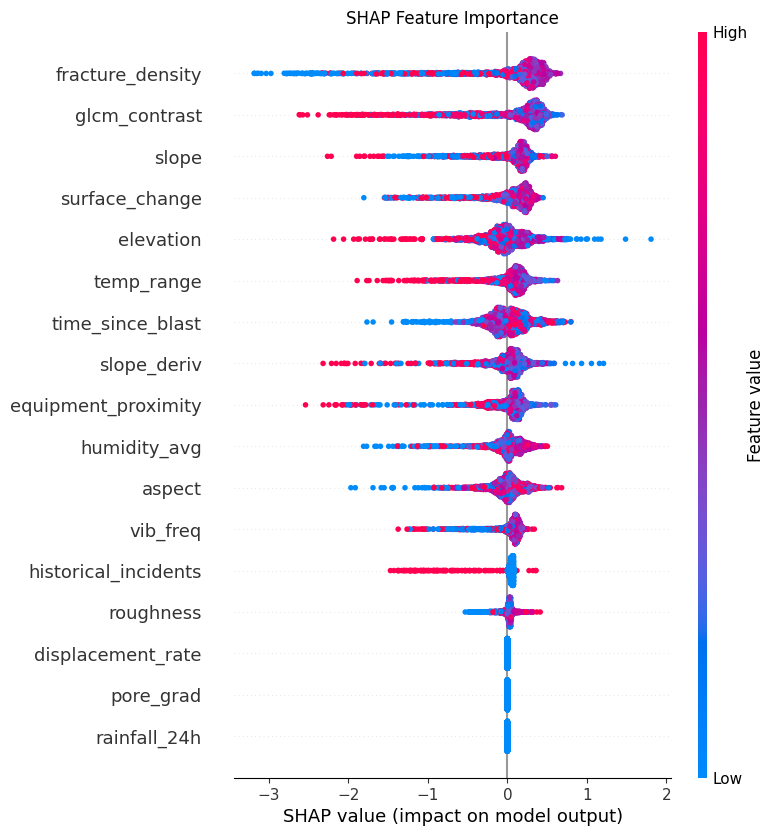

In [10]:
   # Train with Imbalance Handling
   smote = SMOTE(random_state=42)
   X_res, y_res = smote.fit_resample(X_spatial, y)

   X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

   model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
   model.fit(X_train, y_train)

   y_pred = model.predict(X_test)
   print("Classification Report:\n", classification_report(y_test, y_pred))

   # SHAP Interpretability
   explainer = shap.Explainer(model)
   shap_values = explainer(X_test)
   shap.summary_plot(shap_values, X_test, show=False)
   plt.title("SHAP Feature Importance")
   plt.show()  # Displays inline in Colab


In [11]:
# Predict on New Data (simulate real-time)
X_new = X_spatial.copy()
prob_rockfall = model.predict_proba(X_new)[:, 1]

# Probabilistic Risk Score
def compute_risk_score(prob_rockfall, slope, rainfall, displacement):
    risk = 1 / (1 + np.exp(-(prob_rockfall * 10 + slope/10 + rainfall/5 + displacement/0.1)))
    return np.clip(risk, 0, 1)

risk_scores = compute_risk_score(prob_rockfall, spatial_df['slope'], spatial_df['rainfall_24h'], spatial_df['displacement_rate'])

# ALARP-Based Alerts
def assess_risk_and_alert(prob_rockfall, spatial_df, risk_scores):
    alerts = []
    for idx, row in spatial_df.iterrows():
        risk = risk_scores[idx]
        if risk < 0.001:
            severity, action = "Low Risk (Green)", "Continue operations."
        elif risk < 0.01:
            severity, action = "Moderate Risk (Yellow)", "Increase vigilance."
        elif risk < 0.05:
            severity, action = "High Risk (Orange)", "Prepare evacuation."
        else:
            severity, action = "Imminent Risk (Red)", "Evacuate immediately!"

        if severity != "Low Risk (Green)":
            alerts.append({'cell_id': row['cell_id'], 'x': row['x'], 'y': row['y'],
                           'risk': risk, 'severity': severity, 'action': action})
            print(f"ALERT: Cell {row['cell_id']} ({row['x']:.1f}, {row['y']:.1f}): {severity} - {action} (Risk: {risk:.3f})")

    return alerts

alerts = assess_risk_and_alert(prob_rockfall, spatial_df, risk_scores)
print(f"\nTotal Alerts Generated: {len(alerts)}")

# Risk Map (Interactive Folium)
def create_risk_map(spatial_df, risk_scores):
    m = folium.Map(location=[spatial_df['y'].mean(), spatial_df['x'].mean()], zoom_start=10)
    for idx, row in spatial_df.iterrows():
        risk = risk_scores[idx]
        color = 'green' if risk < 0.001 else 'yellow' if risk < 0.01 else 'orange' if risk < 0.05 else 'red'
        folium.CircleMarker(
            location=[row['y'], row['x']],
            radius=5, popup=f"Cell {row['cell_id']}: Risk {risk:.3f}",
            color=color, fill=True, fillColor=color
        ).add_to(m)
    return m

m = create_risk_map(spatial_df, risk_scores)
m.save('risk_map.html')  # Download this file from Colab (Files tab)
print("Risk Map saved as 'risk_map.html' - Open in browser for interactive view!")
display(m)  # Tries to display in Colab (may need folium's display function)

Streaming output truncated to the last 5000 lines.
ALERT: Cell 3.0 (3.0, 0.0): Imminent Risk (Red) - Evacuate immediately! (Risk: 1.000)
ALERT: Cell 4.0 (4.0, 0.0): Imminent Risk (Red) - Evacuate immediately! (Risk: 1.000)
ALERT: Cell 5.0 (5.1, 0.0): Imminent Risk (Red) - Evacuate immediately! (Risk: 1.000)
ALERT: Cell 6.0 (6.1, 0.0): Imminent Risk (Red) - Evacuate immediately! (Risk: 1.000)
ALERT: Cell 7.0 (7.1, 0.0): Imminent Risk (Red) - Evacuate immediately! (Risk: 1.000)
ALERT: Cell 8.0 (8.1, 0.0): Imminent Risk (Red) - Evacuate immediately! (Risk: 1.000)
ALERT: Cell 9.0 (9.1, 0.0): Imminent Risk (Red) - Evacuate immediately! (Risk: 1.000)
ALERT: Cell 10.0 (10.1, 0.0): Imminent Risk (Red) - Evacuate immediately! (Risk: 1.000)
ALERT: Cell 11.0 (11.1, 0.0): Imminent Risk (Red) - Evacuate immediately! (Risk: 1.000)
ALERT: Cell 12.0 (12.1, 0.0): Imminent Risk (Red) - Evacuate immediately! (Risk: 1.000)
ALERT: Cell 13.0 (13.1, 0.0): Imminent Risk (Red) - Evacuate immediately! (Risk: 1.